K-fold Cross Validation

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style


In [2]:

MODEL_NAME = f"model-{time.asctime()}"  # gives a dynamic model name, to just help with things getting messy over
# time.

BATCH_SIZE = 100
k=5
EPOCHS = 5

In [3]:
REBUILD_DATA = False  # set to true to one once, then back to false unless you want to change something in your


In [4]:

# training data.


class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[
                            self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot
                        # print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        # print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:', dogsvcats.catcount)
        print('Dogs:', dogsvcats.dogcount)


In [5]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
#        self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 64, 5)
#        self.bn2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn1 = nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.AlphaDropout(p=0.3)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

        '''>>> # With Learnable Parameters
        >>> m = nn.BatchNorm2d(100)
        >>> # Without Learnable Parameters
        >>> m = nn.BatchNorm2d(100, affine=False)
        >>> input = torch.randn(20, 100, 35, 45)
        >>> output = m(input)'''

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        x = self.dropout(x)
        return F.softmax(x, dim=1)

In [8]:
net = Net().to(device)

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler 
# help(SubsetRandomSampler)

In [10]:
data = np.load("training_data.npy", allow_pickle=True)
print(len(data))

24998


In [11]:
train_data = torch.Tensor([i[0] for i in data]).view(-1, 50, 50) 
train_data = train_data / 255.0

print(train_data.size())
test_data = torch.Tensor([i[1] for i in data])

torch.Size([24998, 50, 50])


In [12]:
train_sampler = SubsetRandomSampler(list(range(int(len(data)*0.8+1))))
valid_sampler = SubsetRandomSampler(list(range(int(len(data)*0.2))))

print(int(len(data)*0.8), int(len(data)*0.2), int(len(data)*0.2)+int(len(data)*0.8))

19998 4999 24997


In [13]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, sampler= train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, sampler= valid_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE)

In [14]:
print(len(test_loader.sampler),len(train_loader.sampler), len(valid_loader.sampler))

24998 19999 4999


In [15]:
print(len(list(iter(train_loader))))# 200 batches of size 100, (one is 99)

200


In [16]:
print(len(list(iter(test_loader))))# 250 batches of size 100, (one is 98)

250


In [17]:
print(len(list(iter(valid_loader))))# 50 batches of size 100, (one is 99)

50


In [18]:
"""VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]"""

In [19]:
def CrossValidation(net):
    for i in range(k):
        valid_sampler = SubsetRandomSampler(list(range(int(len(data)*0.2))))
        valid_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE)
            #print(list(iter(valid_loader)))

        train_sampler = SubsetRandomSampler(list(range(int(len(data)*0.8+1))))
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE)

        test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE)

        with open("model_new.log", "a") as f:
            for epoch in tqdm(range(EPOCHS)):
                    batch_X = next(iter(train_loader)).view(-1, 1, 50, 50)
                    batch_y = next(iter(test_loader))

                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    acc, loss = fwd_pass(batch_X, batch_y, train_=True)

                    batch_val = next(iter(valid_loader)).view(-1,1,50,50)
                    batch_val = batch_val.to(device)
                    val_acc, val_loss = fwd_pass(batch_val, batch_y)

                        # print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                        # f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                        # just to show the above working, and then get out:
                    f.write(
                            f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},"
                            f"{round(float(val_acc), 2)},{round(float(val_loss), 4)},{epoch}\n")



In [20]:

def create_acc_loss_graph(model_name):
    contents = open("model_new.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

In [21]:
#parameters
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [22]:
def fwd_pass(X_, y_, train_=False):
    if train_:
        net.zero_grad()

    outputs = net(X_)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y_)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y_)

    if train_:
        loss.backward()
        optimizer.step()

    return acc, loss

In [23]:
style.use("ggplot")

print(MODEL_NAME)


model-Fri Jul 17 17:24:24 2020


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


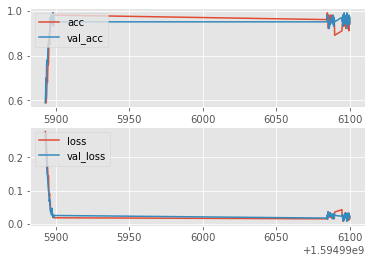

In [33]:
CrossValidation(net)
create_acc_loss_graph(MODEL_NAME)

In [34]:
test_X = train_data[-100:].view(-1, 1, 50, 50)
test_y = test_data[-100:]

test_X, test_y = test_X.to(device), test_y.to(device)

final_acc, final_loss = fwd_pass(test_X, test_y)


In [35]:
print(final_acc,":)", final_loss)

0.53 :) tensor(0.3669, device='cuda:0', grad_fn=<MseLossBackward>)


In [27]:
#help(random_split)
a = torch.arange(10).reshape(5,2)
#b = random_split(a, [5])
#c1, c2 = torch.split(a, [2,3])
#print(a[:1],":)", a[1:])
print(a)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])


In [28]:
"""for i in range(2):
    valid_sampler = SubsetRandomSampler(list(range(int(4))))
    train_sampler = SubsetRandomSampler(list(range(int(2))))
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 10, sampler= valid_sampler)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = 1, sampler= train_sampler)
    print(next(iter(valid_loader)))
    print(":)")
    # print((train_loader))
    print(":(")"""

In [36]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 5, 5])
conv3.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
bn1.weight 	 torch.Size([512])
bn1.bias 	 torch.Size([512])
bn1.running_mean 	 torch.Size([512])
bn1.running_var 	 torch.Size([512])
bn1.num_batches_tracked 	 torch.Size([])
fc2.weight 	 torch.Size([2, 512])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {1694418366536: {'step': 75, 'exp_avg': tensor([[[[-5.3495e-06,  4.1351e-06,  8.2205e-06,  9.1187e-06,  1.5412e-05],
          [ 2.4602e-06, -2.6406e-07,  8.6958e-06,  1.3125e-05,  9.5920e-06],
          [ 2.1940e-06,  3.5679e-06,  6.5186e-06,  1.1279e-05,  8.0244e-06],
          [ 5.8854e-06,  7.5617e-06,  9.2841e-06,  1.0700e-05,  7.8260e-06],
          [ 1.1840e-05,  1.5584e-05,  1.8964e-05,  1.3655e-05,  1.1589e-05]]],


  

In [37]:
PATH = "model/model.pt"

torch.save(net.state_dict(), PATH)

In [38]:
model = Net().to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): AlphaDropout(p=0.3, inplace=False)
)

In [39]:
PATH_MODEL = "model/whole_model.pt"

torch.save(net, PATH_MODEL)

C:\Program Files\Python37\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [40]:
model = torch.load(PATH_MODEL)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): AlphaDropout(p=0.3, inplace=False)
)

In [41]:
PATH_OPT = "model/optimizer.pt"

torch.save(optimizer, PATH_OPT)

opt = torch.load(PATH_OPT)


In [42]:
model.train()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): AlphaDropout(p=0.3, inplace=False)
)

In [43]:
optimizera = optim.Adam(net.parameters(), lr=0.001)
optimizera.load_state_dict(opt.state_dict())

In [44]:
print("Optimizer's state_dict:")
for var_name in optimizera.state_dict():
    print(var_name, "\t", optimizera.state_dict()[var_name])

Optimizer's state_dict:
state 	 {1694418366536: {'step': 75, 'exp_avg': tensor([[[[-5.3495e-06,  4.1351e-06,  8.2205e-06,  9.1187e-06,  1.5412e-05],
          [ 2.4602e-06, -2.6406e-07,  8.6958e-06,  1.3125e-05,  9.5920e-06],
          [ 2.1940e-06,  3.5679e-06,  6.5186e-06,  1.1279e-05,  8.0244e-06],
          [ 5.8854e-06,  7.5617e-06,  9.2841e-06,  1.0700e-05,  7.8260e-06],
          [ 1.1840e-05,  1.5584e-05,  1.8964e-05,  1.3655e-05,  1.1589e-05]]],


        [[[-7.6785e-07, -1.6942e-06, -8.1677e-07, -2.1509e-06, -2.1251e-06],
          [-1.5737e-06, -1.4328e-06, -1.7723e-06, -2.1568e-06, -1.9311e-06],
          [-1.3733e-06, -2.5209e-06, -2.6164e-06, -1.1207e-06, -1.2264e-06],
          [-1.8802e-06, -3.5215e-06, -2.5385e-06, -1.9588e-06, -9.1742e-07],
          [-2.4080e-06, -4.0890e-06, -2.5080e-06, -3.4072e-06, -1.5207e-06]]],


        [[[-6.4622e-06,  1.3300e-06, -1.1047e-05, -1.4751e-05, -1.1096e-05],
          [-1.0146e-05, -7.5664e-06, -1.6490e-05, -1.8138e-05, -9.8838e-0

In [45]:
optimizerb = optim.Adam(net.parameters(), lr=0.001)
print("Optimizer's state_dict:")
for var_name in optimizerb.state_dict():
    print(var_name, "\t", optimizerb.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [1694418366536, 1694418506232, 1694418506592, 1694418505944, 1694418506664, 1694418506808, 1694418507024, 1694418506736, 1694418507384, 1694418507600, 1694418507168, 1694418507744]}]


:)


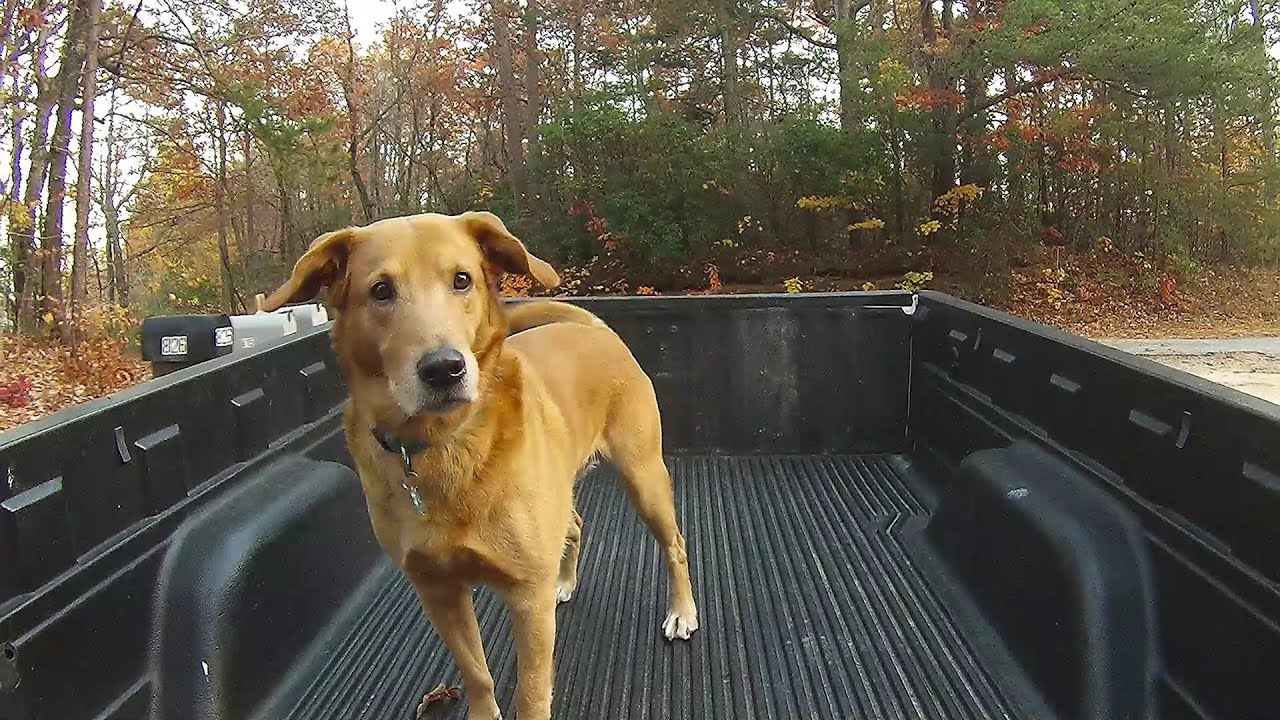

In [46]:
from IPython.display import display
from PIL import Image

def load_image(path):
    img_PIL = Image.open(path)
    display(img_PIL)

 
# load an image and predict the class
def run_example():
    print(":)")
 
# entry point, run the example
run_example()

path = "samples/sample_image.jpg"
load_image(path)

In [47]:
help(Image.open)

Help on function open in module PIL.Image:

open(fp, mode='r')
    Opens and identifies the given image file.
    
    This is a lazy operation; this function identifies the file, but
    the file remains open and the actual image data is not read from
    the file until you try to process the data (or call the
    :py:meth:`~PIL.Image.Image.load` method).  See
    :py:func:`~PIL.Image.new`. See :ref:`file-handling`.
    
    :param fp: A filename (string), pathlib.Path object or a file object.
       The file object must implement :py:meth:`~file.read`,
       :py:meth:`~file.seek`, and :py:meth:`~file.tell` methods,
       and be opened in binary mode.
    :param mode: The mode.  If given, this argument must be "r".
    :returns: An :py:class:`~PIL.Image.Image` object.
    :exception FileNotFoundError: If the file cannot be found.
    :exception PIL.UnidentifiedImageError: If the image cannot be opened and
       identified.
    :exception ValueError: If the ``mode`` is not "r", or i

True


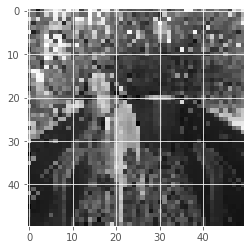

In [48]:
IMG_SIZE = 50
path = "D:/projects/Neural_Networks/coursera_v2/coursera/samples/sample_image.JPG"
print(os.path.exists(path))

img = cv2.imread(r"D:/projects/Neural_Networks/coursera_v2/coursera/samples/sample_image.JPG", cv2.IMREAD_GRAYSCALE )

#if img == None: # older numpy / py2
    # fail !!
#    print("fail!1")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img, cmap='gray')

In [49]:
x = torch.Tensor(img).view(-1, 50,50)
test_x = x.view(-1, 1, 50, 50)
test_x = test_x.to(device)
net.eval()
yhat = net(test_x)
print(yhat)

tensor([[0., 1.]], device='cuda:0', grad_fn=<SoftmaxBackward>)


True


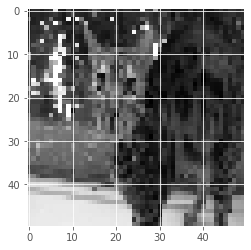

In [50]:
path = "D:/projects/Neural_Networks/coursera_v2/coursera/samples/cat.JPG"
print(os.path.exists(path))

img = cv2.imread(r"D:/projects/Neural_Networks/coursera_v2/coursera/samples/cat.JPG", cv2.IMREAD_GRAYSCALE )

#if img == None: # older numpy / py2
    # fail !!
#    print("fail!1")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img, cmap='gray')

In [51]:
x = torch.Tensor(img).view(-1, 50,50)
test_x = x.view(-1, 1, 50, 50)
test_x = test_x.to(device)
net.eval()
yhat = net(test_x)
print(yhat)

tensor([[0., 1.]], device='cuda:0', grad_fn=<SoftmaxBackward>)


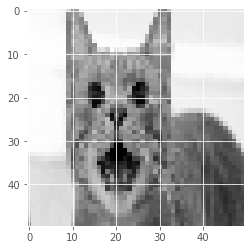

In [52]:
img = cv2.imread(r"D:/projects/Neural_Networks/coursera_v2/coursera/samples/cat2.JPG", cv2.IMREAD_GRAYSCALE )

#if img == None: # older numpy / py2
    # fail !!
#    print("fail!1")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img, cmap='gray')

In [75]:
#while True:
x = torch.Tensor(img).view(-1, 50,50)
test_x = x.view(-1, 1, 50, 50)
test_x = test_x.to(device)
model.eval()
yhat = model(test_x)
 #   if yhat == ([[0., 1.]]):
print(yhat)
print([yhat== ([[0., 1.]])])
 #       break

tensor([[0., 1.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
[False]


In [76]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])